### Import

In [ ]:
! pip install rdt
! pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 599.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 4.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from torch import nn
import torch
from torch import optim
from torch.nn import BatchNorm1d, Dropout, LeakyReLU, Linear, Module, ReLU, Sequential, functional
from tqdm import tqdm

import contextlib
from collections import namedtuple

import numpy as np
import pandas as pd
from joblib import Parallel, delayed

from rdt.transformers import ClusterBasedNormalizer, OneHotEncoder
from scipy.stats import ks_2samp, anderson_ksamp
import ot

### Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir = "/content/drive/MyDrive/GenHack3/data/"
S1 = pd.read_csv(dir + "station_49.csv")
S2 = pd.read_csv(dir + "station_80.csv")
S3 = pd.read_csv(dir + "station_40.csv")
S4 = pd.read_csv(dir + "station_63.csv")
noise = np.load(dir + "noise.npy")

In [ ]:
S1.head(2)

,YEAR,W_1,W_2,W_3,W_4,W_5,W_6,W_7,W_8,W_9,W_10,W_11,W_12,W_13,W_14,W_15,W_16,W_17,W_18,YIELD
0,0,20.487164,26.089329,25.394672,27.024097,24.426756,26.420241,25.534358,21.369482,18.577526,1.384519,1.401463,0.862322,1.536162,1.640605,0.204141,1.078367,1.379353,0.886892,6.37
1,1,21.430837,22.228488,24.205256,29.859199,30.434175,26.467017,27.300290,22.509277,16.388211,1.237347,1.467149,1.357827,0.875649,0.305032,1.673852,0.214576,0.533683,1.496904,5.54


In [ ]:
noise.shape

(10000, 50)

In [ ]:
(S1.shape == S2.shape) and (S3.shape == S4.shape) and (S1.shape == S3.shape) and (S3.shape == (10000, 20))

True

In [ ]:
S1.columns = [f'S1_{col}' for col in S1.columns]
S2.columns = [f'S2_{col}' for col in S2.columns]
S3.columns = [f'S3_{col}' for col in S3.columns]
S4.columns = [f'S4_{col}' for col in S4.columns]

data_use = pd.concat([S1, S2, S3, S4], axis=1)

data_use.head()

,S1_YEAR,S1_W_1,S1_W_2,S1_W_3,S1_W_4,S1_W_5,S1_W_6,S1_W_7,S1_W_8,S1_W_9,...,S4_W_10,S4_W_11,S4_W_12,S4_W_13,S4_W_14,S4_W_15,S4_W_16,S4_W_17,S4_W_18,S4_YIELD
0,0,20.487164,26.089329,25.394672,27.024097,24.426756,26.420241,25.534358,21.369482,18.577526,...,1.462204,3.951453,2.101091,1.141454,2.167033,7.972668,1.555216,6.219460,2.081787,5.97
1,1,21.430837,22.228488,24.205256,29.859199,30.434175,26.467017,27.300290,22.509277,16.388211,...,1.036085,0.879651,5.583977,0.319974,1.612761,3.304209,0.060819,1.540583,3.214933,5.77
2,2,18.841767,25.165941,24.169267,28.742330,27.342035,27.945379,25.710641,22.343698,19.797961,...,3.295700,2.556876,2.165009,2.165768,1.791010,3.012968,4.316012,2.021236,0.814444,8.65
3,3,18.359661,20.235180,22.714217,30.017206,27.192345,23.159092,23.287619,19.477149,18.917730,...,2.872424,3.686682,4.716563,2.837129,0.638416,2.147741,3.114913,1.106072,0.870118,1.07
4,4,21.125963,23.270596,22.949896,26.594044,31.557704,28.464610,27.306957,26.999664,16.666535,...,2.240781,2.920387,1.472874,1.235341,3.050564,0.899664,1.561179,0.975300,3.242242,7.40


In [ ]:
columns_to_keep = [col for col in data_use.columns if "YEAR" not in col]
data_use = data_use[columns_to_keep]

In [ ]:
Q1, Q2, Q3, Q4 = 3.3241, 5.1292, 6.4897, 7.1301
conditions = (
    (data_use.S1_W_13 + data_use.S1_W_14 + data_use.S1_W_15 <= Q1) &
     (data_use.S2_W_13 + data_use.S2_W_14 + data_use.S2_W_15 <= Q2) &
      (data_use.S3_W_13 + data_use.S3_W_14 + data_use.S3_W_15 <= Q3) &
       (data_use.S4_W_13 + data_use.S4_W_14 + data_use.S4_W_15 <= Q4)
)

data_use['condition'] = np.where(conditions, 'Oui', 'Non')

In [ ]:
data_interest = data_use[data_use.condition == 'Oui']

In [ ]:
data_interest.shape

(1000, 77)

In [ ]:
data_interest.head()

,S1_W_1,S1_W_2,S1_W_3,S1_W_4,S1_W_5,S1_W_6,S1_W_7,S1_W_8,S1_W_9,S1_W_10,...,S4_W_11,S4_W_12,S4_W_13,S4_W_14,S4_W_15,S4_W_16,S4_W_17,S4_W_18,S4_YIELD,condition
1,21.430837,22.228488,24.205256,29.859199,30.434175,26.467017,27.300290,22.509277,16.388211,1.237347,...,0.879651,5.583977,0.319974,1.612761,3.304209,0.060819,1.540583,3.214933,5.77,Oui
2,18.841767,25.165941,24.169267,28.742330,27.342035,27.945379,25.710641,22.343698,19.797961,2.509957,...,2.556876,2.165009,2.165768,1.791010,3.012968,4.316012,2.021236,0.814444,8.65,Oui
10,23.067487,21.989987,26.730305,27.207224,28.277049,26.121537,30.583426,22.363784,15.826520,1.832929,...,2.468359,0.930159,1.402261,2.402111,2.140366,1.821273,1.763787,4.698325,6.34,Oui
28,24.441997,24.273763,23.400111,27.344886,25.011067,28.047828,25.841452,20.996116,16.747943,0.877913,...,1.782715,3.127549,0.520928,1.781335,2.064324,2.425123,3.876324,1.230727,3.93,Oui
33,21.562630,22.283709,25.263382,25.713687,28.258033,28.984649,26.601343,23.831066,17.453389,1.081927,...,5.300191,0.870621,0.466796,0.665607,2.231320,2.971977,1.737167,3.273389,5.58,Oui


In [ ]:
Yield = np.array([data_interest.S1_YIELD,data_interest.S2_YIELD,data_interest.S3_YIELD,data_interest.S4_YIELD]).T

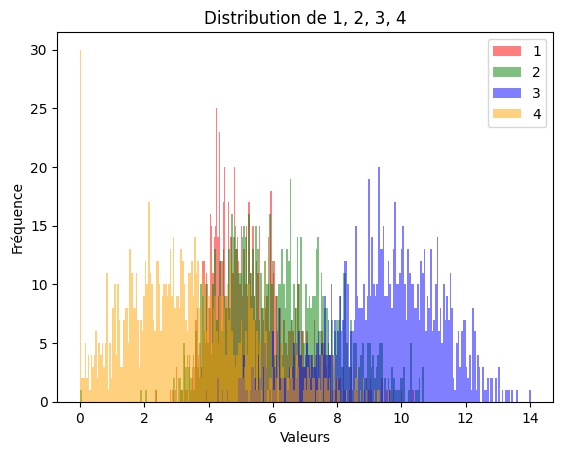

In [ ]:
plt.hist(data_interest.S1_YIELD, bins=200, alpha=0.5, color='red', label='1')
plt.hist(data_interest.S2_YIELD, bins=200, alpha=0.5, color='green', label='2')
plt.hist(data_interest.S3_YIELD, bins=200, alpha=0.5, color='blue', label='3')
plt.hist(data_interest.S4_YIELD, bins=200, alpha=0.5, color='orange', label='4')

plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Distribution de 1, 2, 3, 4')

plt.legend()

plt.show()

Adapté de la source ci apres :
https://arxiv.org/abs/1907.00503

### Base Synth

In [ ]:
@contextlib.contextmanager
def set_random_states(random_state, set_model_random_state):
    """Context manager for managing the random state.

    Args:
        random_state (int or tuple):
            The random seed or a tuple of (numpy.random.RandomState, torch.Generator).
        set_model_random_state (function):
            Function to set the random state on the model.
    """
    original_np_state = np.random.get_state()
    original_torch_state = torch.get_rng_state()

    random_np_state, random_torch_state = random_state

    np.random.set_state(random_np_state.get_state())
    torch.set_rng_state(random_torch_state.get_state())

    try:
        yield
    finally:
        current_np_state = np.random.RandomState()
        current_np_state.set_state(np.random.get_state())
        current_torch_state = torch.Generator()
        current_torch_state.set_state(torch.get_rng_state())
        set_model_random_state((current_np_state, current_torch_state))

        np.random.set_state(original_np_state)
        torch.set_rng_state(original_torch_state)


def random_state(function):
    """Set the random state before calling the function.

    Args:
        function (Callable):
            The function to wrap around.
    """

    def wrapper(self, *args, **kwargs):
        if self.random_states is None:
            return function(self, *args, **kwargs)

        else:
            with set_random_states(self.random_states, self.set_random_state):
                return function(self, *args, **kwargs)

    return wrapper


class BaseSynthesizer:
    """Base class for all default synthesizers of ``CTGAN``."""

    random_states = None

    def __getstate__(self):
        """Improve pickling state for ``BaseSynthesizer``.

        Convert to ``cpu`` device before starting the pickling process in order to be able to
        load the model even when used from an external tool such as ``SDV``. Also, if
        ``random_states`` are set, store their states as dictionaries rather than generators.

        Returns:
            dict:
                Python dict representing the object.
        """
        device_backup = self._device
        self.set_device(torch.device('cpu'))
        state = self.__dict__.copy()
        self.set_device(device_backup)
        if (
            isinstance(self.random_states, tuple) and
            isinstance(self.random_states[0], np.random.RandomState) and
            isinstance(self.random_states[1], torch.Generator)
        ):
            state['_numpy_random_state'] = self.random_states[0].get_state()
            state['_torch_random_state'] = self.random_states[1].get_state()
            state.pop('random_states')

        return state

    def __setstate__(self, state):
        """Restore the state of a ``BaseSynthesizer``.

        Restore the ``random_states`` from the state dict if those are present and then
        set the device according to the current hardware.
        """
        if '_numpy_random_state' in state and '_torch_random_state' in state:
            np_state = state.pop('_numpy_random_state')
            torch_state = state.pop('_torch_random_state')

            current_torch_state = torch.Generator()
            current_torch_state.set_state(torch_state)

            current_numpy_state = np.random.RandomState()
            current_numpy_state.set_state(np_state)
            state['random_states'] = (
                current_numpy_state,
                current_torch_state
            )

        self.__dict__ = state
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.set_device(device)

    def save(self, path):
        """Save the model in the passed `path`."""
        device_backup = self._device
        self.set_device(torch.device('cpu'))
        torch.save(self, path)
        self.set_device(device_backup)

    @classmethod
    def load(cls, path):
        """Load the model stored in the passed `path`."""
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = torch.load(path)
        model.set_device(device)
        return model

    def set_random_state(self, random_state):
        """Set the random state.

        Args:
            random_state (int, tuple, or None):
                Either a tuple containing the (numpy.random.RandomState, torch.Generator)
                or an int representing the random seed to use for both random states.
        """
        if random_state is None:
            self.random_states = random_state
        elif isinstance(random_state, int):
            self.random_states = (
                np.random.RandomState(seed=random_state),
                torch.Generator().manual_seed(random_state),
            )
        elif (
            isinstance(random_state, tuple) and
            isinstance(random_state[0], np.random.RandomState) and
            isinstance(random_state[1], torch.Generator)
        ):
            self.random_states = random_state
        else:
            raise TypeError(
                f'`random_state` {random_state} expected to be an int or a tuple of '
                '(`np.random.RandomState`, `torch.Generator`)')

### DataSampler

In [ ]:
class DataSampler(object):
    """DataSampler samples the conditional vector and corresponding data for CTGAN."""

    def __init__(self, data, output_info, log_frequency):
        self._data_length = len(data)

        def is_discrete_column(column_info):
            return (len(column_info) == 1
                    and column_info[0].activation_fn == 'softmax')

        n_discrete_columns = sum(
            [1 for column_info in output_info if is_discrete_column(column_info)])

        self._discrete_column_matrix_st = np.zeros(
            n_discrete_columns, dtype='int32')

        # Store the row id for each category in each discrete column.
        # For example _rid_by_cat_cols[a][b] is a list of all rows with the
        # a-th discrete column equal value b.
        self._rid_by_cat_cols = []

        # Compute _rid_by_cat_cols
        st = 0
        for column_info in output_info:
            if is_discrete_column(column_info):
                span_info = column_info[0]
                ed = st + span_info.dim

                rid_by_cat = []
                for j in range(span_info.dim):
                    rid_by_cat.append(np.nonzero(data[:, st + j])[0])
                self._rid_by_cat_cols.append(rid_by_cat)
                st = ed
            else:
                st += sum([span_info.dim for span_info in column_info])
        assert st == data.shape[1]

        # Prepare an interval matrix for efficiently sample conditional vector
        max_category = max([
            column_info[0].dim
            for column_info in output_info
            if is_discrete_column(column_info)
        ], default=0)

        self._discrete_column_cond_st = np.zeros(n_discrete_columns, dtype='int32')
        self._discrete_column_n_category = np.zeros(n_discrete_columns, dtype='int32')
        self._discrete_column_category_prob = np.zeros((n_discrete_columns, max_category))
        self._n_discrete_columns = n_discrete_columns
        self._n_categories = sum([
            column_info[0].dim
            for column_info in output_info
            if is_discrete_column(column_info)
        ])

        st = 0
        current_id = 0
        current_cond_st = 0
        for column_info in output_info:
            if is_discrete_column(column_info):
                span_info = column_info[0]
                ed = st + span_info.dim
                category_freq = np.sum(data[:, st:ed], axis=0)
                if log_frequency:
                    category_freq = np.log(category_freq + 1)
                category_prob = category_freq / np.sum(category_freq)
                self._discrete_column_category_prob[current_id, :span_info.dim] = category_prob
                self._discrete_column_cond_st[current_id] = current_cond_st
                self._discrete_column_n_category[current_id] = span_info.dim
                current_cond_st += span_info.dim
                current_id += 1
                st = ed
            else:
                st += sum([span_info.dim for span_info in column_info])

    def _random_choice_prob_index(self, discrete_column_id):
        probs = self._discrete_column_category_prob[discrete_column_id]
        r = np.expand_dims(np.random.rand(probs.shape[0]), axis=1)
        return (probs.cumsum(axis=1) > r).argmax(axis=1)

    def sample_condvec(self, batch):
        """Generate the conditional vector for training.

        Returns:
            cond (batch x #categories):
                The conditional vector.
            mask (batch x #discrete columns):
                A one-hot vector indicating the selected discrete column.
            discrete column id (batch):
                Integer representation of mask.
            category_id_in_col (batch):
                Selected category in the selected discrete column.
        """
        if self._n_discrete_columns == 0:
            return None

        discrete_column_id = np.random.choice(
            np.arange(self._n_discrete_columns), batch)

        cond = np.zeros((batch, self._n_categories), dtype='float32')
        mask = np.zeros((batch, self._n_discrete_columns), dtype='float32')
        mask[np.arange(batch), discrete_column_id] = 1
        category_id_in_col = self._random_choice_prob_index(discrete_column_id)
        category_id = (self._discrete_column_cond_st[discrete_column_id] + category_id_in_col)
        cond[np.arange(batch), category_id] = 1

        return cond, mask, discrete_column_id, category_id_in_col

    def sample_original_condvec(self, batch):
        """Generate the conditional vector for generation use original frequency."""
        if self._n_discrete_columns == 0:
            return None

        category_freq = self._discrete_column_category_prob.flatten()
        category_freq = category_freq[category_freq != 0]
        category_freq = category_freq / np.sum(category_freq)
        col_idxs = np.random.choice(np.arange(len(category_freq)), batch, p=category_freq)
        cond = np.zeros((batch, self._n_categories), dtype='float32')
        cond[np.arange(batch), col_idxs] = 1

        return cond

    def sample_data(self, data, n, col, opt):
        """Sample data from original training data satisfying the sampled conditional vector.

        Args:
            data:
                The training data.
        Returns:
            n:
                n rows of matrix data.
        """
        if col is None:
            idx = np.random.randint(len(data), size=n)
            return data[idx]

        idx = []
        for c, o in zip(col, opt):
            idx.append(np.random.choice(self._rid_by_cat_cols[c][o]))

        return data[idx]

    def dim_cond_vec(self):
        """Return the total number of categories."""
        return self._n_categories

    def generate_cond_from_condition_column_info(self, condition_info, batch):
        """Generate the condition vector."""
        vec = np.zeros((batch, self._n_categories), dtype='float32')
        id_ = self._discrete_column_matrix_st[condition_info['discrete_column_id']]
        id_ += condition_info['value_id']
        vec[:, id_] = 1
        return vec

### DataTransformer

In [ ]:
SpanInfo = namedtuple('SpanInfo', ['dim', 'activation_fn'])
ColumnTransformInfo = namedtuple(
    'ColumnTransformInfo', [
        'column_name', 'column_type', 'transform', 'output_info', 'output_dimensions'
    ]
)


class DataTransformer(object):
    """Data Transformer.

    Model continuous columns with a BayesianGMM and normalize them to a scalar between [-1, 1]
    and a vector. Discrete columns are encoded using a OneHotEncoder.
    """

    def __init__(self, max_clusters=10, weight_threshold=0.005):
        """Create a data transformer.

        Args:
            max_clusters (int):
                Maximum number of Gaussian distributions in Bayesian GMM.
            weight_threshold (float):
                Weight threshold for a Gaussian distribution to be kept.
        """
        self._max_clusters = max_clusters
        self._weight_threshold = weight_threshold

    def _fit_continuous(self, data):
        """Train Bayesian GMM for continuous columns.

        Args:
            data (pd.DataFrame):
                A dataframe containing a column.

        Returns:
            namedtuple:
                A ``ColumnTransformInfo`` object.
        """
        column_name = data.columns[0]
        gm = ClusterBasedNormalizer(
            missing_value_generation='from_column',
            max_clusters=min(len(data), self._max_clusters),
            weight_threshold=self._weight_threshold
        )
        gm.fit(data, column_name)
        num_components = sum(gm.valid_component_indicator)

        return ColumnTransformInfo(
            column_name=column_name, column_type='continuous', transform=gm,
            output_info=[SpanInfo(1, 'tanh'), SpanInfo(num_components, 'softmax')],
            output_dimensions=1 + num_components)

    def _fit_discrete(self, data):
        """Fit one hot encoder for discrete column.

        Args:
            data (pd.DataFrame):
                A dataframe containing a column.

        Returns:
            namedtuple:
                A ``ColumnTransformInfo`` object.
        """
        column_name = data.columns[0]
        ohe = OneHotEncoder()
        ohe.fit(data, column_name)
        num_categories = len(ohe.dummies)

        return ColumnTransformInfo(
            column_name=column_name, column_type='discrete', transform=ohe,
            output_info=[SpanInfo(num_categories, 'softmax')],
            output_dimensions=num_categories)

    def fit(self, raw_data, discrete_columns=()):
        """Fit the ``DataTransformer``.

        Fits a ``ClusterBasedNormalizer`` for continuous columns and a
        ``OneHotEncoder`` for discrete columns.

        This step also counts the #columns in matrix data and span information.
        """
        self.output_info_list = []
        self.output_dimensions = 0
        self.dataframe = True

        if not isinstance(raw_data, pd.DataFrame):
            self.dataframe = False
            # work around for RDT issue #328 Fitting with numerical column names fails
            discrete_columns = [str(column) for column in discrete_columns]
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        self._column_raw_dtypes = raw_data.infer_objects().dtypes
        self._column_transform_info_list = []
        for column_name in raw_data.columns:
            if column_name in discrete_columns:
                column_transform_info = self._fit_discrete(raw_data[[column_name]])
            else:
                column_transform_info = self._fit_continuous(raw_data[[column_name]])

            self.output_info_list.append(column_transform_info.output_info)
            self.output_dimensions += column_transform_info.output_dimensions
            self._column_transform_info_list.append(column_transform_info)

    def _transform_continuous(self, column_transform_info, data):
        column_name = data.columns[0]
        flattened_column = data[column_name].to_numpy().flatten()
        data = data.assign(**{column_name: flattened_column})
        gm = column_transform_info.transform
        transformed = gm.transform(data)

        #  Converts the transformed data to the appropriate output format.
        #  The first column (ending in '.normalized') stays the same,
        #  but the lable encoded column (ending in '.component') is one hot encoded.
        output = np.zeros((len(transformed), column_transform_info.output_dimensions))
        output[:, 0] = transformed[f'{column_name}.normalized'].to_numpy()
        index = transformed[f'{column_name}.component'].to_numpy().astype(int)
        output[np.arange(index.size), index + 1] = 1.0

        return output

    def _transform_discrete(self, column_transform_info, data):
        ohe = column_transform_info.transform
        return ohe.transform(data).to_numpy()

    def _synchronous_transform(self, raw_data, column_transform_info_list):
        """Take a Pandas DataFrame and transform columns synchronous.

        Outputs a list with Numpy arrays.
        """
        column_data_list = []
        for column_transform_info in column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            if column_transform_info.column_type == 'continuous':
                column_data_list.append(self._transform_continuous(column_transform_info, data))
            else:
                column_data_list.append(self._transform_discrete(column_transform_info, data))

        return column_data_list

    def _parallel_transform(self, raw_data, column_transform_info_list):
        """Take a Pandas DataFrame and transform columns in parallel.

        Outputs a list with Numpy arrays.
        """
        processes = []
        for column_transform_info in column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            process = None
            if column_transform_info.column_type == 'continuous':
                process = delayed(self._transform_continuous)(column_transform_info, data)
            else:
                process = delayed(self._transform_discrete)(column_transform_info, data)
            processes.append(process)

        return Parallel(n_jobs=-1)(processes)

    def transform(self, raw_data):
        """Take raw data and output a matrix data."""
        if not isinstance(raw_data, pd.DataFrame):
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        # Only use parallelization with larger data sizes.
        # Otherwise, the transformation will be slower.
        if raw_data.shape[0] < 500:
            column_data_list = self._synchronous_transform(
                raw_data,
                self._column_transform_info_list
            )
        else:
            column_data_list = self._parallel_transform(
                raw_data,
                self._column_transform_info_list
            )

        return np.concatenate(column_data_list, axis=1).astype(float)

    def _inverse_transform_continuous(self, column_transform_info, column_data, sigmas, st):
        gm = column_transform_info.transform
        data = pd.DataFrame(column_data[:, :2], columns=list(gm.get_output_sdtypes()))
        data[data.columns[1]] = np.argmax(column_data[:, 1:], axis=1)
        if sigmas is not None:
            selected_normalized_value = np.random.normal(data.iloc[:, 0], sigmas[st])
            data.iloc[:, 0] = selected_normalized_value

        return gm.reverse_transform(data)

    def _inverse_transform_discrete(self, column_transform_info, column_data):
        ohe = column_transform_info.transform
        data = pd.DataFrame(column_data, columns=list(ohe.get_output_sdtypes()))
        return ohe.reverse_transform(data)[column_transform_info.column_name]

    def inverse_transform(self, data, sigmas=None):
        """Take matrix data and output raw data.

        Output uses the same type as input to the transform function.
        Either np array or pd dataframe.
        """
        st = 0
        recovered_column_data_list = []
        column_names = []
        for column_transform_info in self._column_transform_info_list:
            dim = column_transform_info.output_dimensions
            column_data = data[:, st:st + dim]
            if column_transform_info.column_type == 'continuous':
                recovered_column_data = self._inverse_transform_continuous(
                    column_transform_info, column_data, sigmas, st)
            else:
                recovered_column_data = self._inverse_transform_discrete(
                    column_transform_info, column_data)

            recovered_column_data_list.append(recovered_column_data)
            column_names.append(column_transform_info.column_name)
            st += dim

        recovered_data = np.column_stack(recovered_column_data_list)
        recovered_data = (pd.DataFrame(recovered_data, columns=column_names)
                          .astype(self._column_raw_dtypes))
        if not self.dataframe:
            recovered_data = recovered_data.to_numpy()

        return recovered_data

    def convert_column_name_value_to_id(self, column_name, value):
        """Get the ids of the given `column_name`."""
        discrete_counter = 0
        column_id = 0
        for column_transform_info in self._column_transform_info_list:
            if column_transform_info.column_name == column_name:
                break
            if column_transform_info.column_type == 'discrete':
                discrete_counter += 1

            column_id += 1

        else:
            raise ValueError(f"The column_name `{column_name}` doesn't exist in the data.")

        ohe = column_transform_info.transform
        data = pd.DataFrame([value], columns=[column_transform_info.column_name])
        one_hot = ohe.transform(data).to_numpy()[0]
        if sum(one_hot) == 0:
            raise ValueError(f"The value `{value}` doesn't exist in the column `{column_name}`.")

        return {
            'discrete_column_id': discrete_counter,
            'column_id': column_id,
            'value_id': np.argmax(one_hot)
        }

### Modelisation T-GANs

In [ ]:
class Discriminator(nn.Module):
    """Discriminator for the CTGAN."""

    def __init__(self, input_dim, discriminator_dim, pac=10, transformer_nhead=1, transformer_dim_feedforward=2048):
        super(Discriminator, self).__init__()
        dim = input_dim * pac
        self.pac = pac
        self.pacdim = dim

        # Ajouter des couches transformer
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=transformer_nhead, dim_feedforward=transformer_dim_feedforward)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=1)

        # Ajouter des couches linéaires et d'autres couches discriminatoires
        seq = []
        for item in list(discriminator_dim):
            seq += [Linear(dim, item), LeakyReLU(0.2), Dropout(0.5)]
            dim = item

        seq += [Linear(dim, 1)]
        self.seq = nn.Sequential(*seq)

    def calc_gradient_penalty(self, real_data, fake_data, device='cpu', pac=10, lambda_=10):
        """Compute the gradient penalty."""
        alpha = torch.rand(real_data.size(0) // pac, 1, 1, device=device)
        alpha = alpha.repeat(1, pac, real_data.size(1))
        alpha = alpha.view(-1, real_data.size(1))

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        disc_interpolates = self(interpolates)

        gradients = torch.autograd.grad(
            outputs=disc_interpolates, inputs=interpolates,
            grad_outputs=torch.ones(disc_interpolates.size(), device=device),
            create_graph=True, retain_graph=True, only_inputs=True
        )[0]

        gradients_view = gradients.view(-1, pac * real_data.size(1)).norm(2, dim=1) - 1
        gradient_penalty = ((gradients_view) ** 2).mean() * lambda_

        return gradient_penalty

    def forward(self, x):
        # Appliquer la transformation avec le transformer
        x_transformed = self.transformer(x)

        # Appliquer les autres couches discriminatoires
        return self.seq(x_transformed)


class Residual(Module):
    """Residual layer for the CTGAN."""

    def __init__(self, i, o):
        super(Residual, self).__init__()
        self.fc = Linear(i, o)
        self.bn = BatchNorm1d(o)
        self.relu = ReLU()

    def forward(self, input_):
        """Apply the Residual layer to the `input_`."""
        out = self.fc(input_)
        out = self.bn(out)
        out = self.relu(out)
        return torch.cat([out, input_], dim=1)


class Generator(nn.Module):
    """Generator for the CTGAN."""

    def __init__(self, embedding_dim, generator_dim, data_dim, transformer_nhead=1, transformer_dim_feedforward=2048):
        super(Generator, self).__init__()
        dim = embedding_dim

        # Ajouter des couches transformer
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=transformer_nhead, dim_feedforward=transformer_dim_feedforward)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=1)

        # Ajouter des couches résiduelles
        seq = []
        for item in list(generator_dim):
            seq += [Residual(dim, item)]
            dim += item

        seq.append(Linear(dim, data_dim))
        self.seq = nn.Sequential(*seq)

    def forward(self, input_):
        """Apply the Generator to the `input_`."""
        # Appliquer la transformation avec le transformer
        input_transformed = self.transformer(input_)

        # Appliquer les autres couches résiduelles
        data = self.seq(input_transformed)
        return data


class CTGAN(BaseSynthesizer):
    """Conditional Table GAN Synthesizer.

    This is the core class of the CTGAN project, where the different components
    are orchestrated together.
    For more details about the process, please check the [Modeling Tabular data using
    Conditional GAN](https://arxiv.org/abs/1907.00503) paper.

    Args:
        embedding_dim (int):
            Size of the random sample passed to the Generator. Defaults to 128.
        generator_dim (tuple or list of ints):
            Size of the output samples for each one of the Residuals. A Residual Layer
            will be created for each one of the values provided. Defaults to (256, 256).
        discriminator_dim (tuple or list of ints):
            Size of the output samples for each one of the Discriminator Layers. A Linear Layer
            will be created for each one of the values provided. Defaults to (256, 256).
        generator_lr (float):
            Learning rate for the generator. Defaults to 2e-4.
        generator_decay (float):
            Generator weight decay for the Adam Optimizer. Defaults to 1e-6.
        discriminator_lr (float):
            Learning rate for the discriminator. Defaults to 2e-4.
        discriminator_decay (float):
            Discriminator weight decay for the Adam Optimizer. Defaults to 1e-6.
        batch_size (int):
            Number of data samples to process in each step.
        discriminator_steps (int):
            Number of discriminator updates to do for each generator update.
            From the WGAN paper: https://arxiv.org/abs/1701.07875. WGAN paper
            default is 5. Default used is 1 to match original CTGAN implementation.
        log_frequency (boolean):
            Whether to use log frequency of categorical levels in conditional
            sampling. Defaults to ``True``.
        verbose (boolean):
            Whether to have print statements for progress results. Defaults to ``False``.
        epochs (int):
            Number of training epochs. Defaults to 300.
        pac (int):
            Number of samples to group together when applying the discriminator.
            Defaults to 10.
        cuda (bool):
            Whether to attempt to use cuda for GPU computation.
            If this is False or CUDA is not available, CPU will be used.
            Defaults to ``True``.
    """

    def __init__(self, embedding_dim=50, generator_dim=(256, 256), discriminator_dim=(256, 256),
                 generator_lr=2e-4, generator_decay=1e-6, discriminator_lr=2e-4,
                 discriminator_decay=1e-6, batch_size=500, discriminator_steps=1,
                 log_frequency=True, verbose=False, epochs=300, pac=10, cuda=True):

        assert batch_size % 2 == 0

        self._embedding_dim = embedding_dim
        self._generator_dim = generator_dim
        self._discriminator_dim = discriminator_dim

        self._generator_lr = generator_lr
        self._generator_decay = generator_decay
        self._discriminator_lr = discriminator_lr
        self._discriminator_decay = discriminator_decay

        self._batch_size = batch_size
        self._discriminator_steps = discriminator_steps
        self._log_frequency = log_frequency
        self._verbose = verbose
        self._epochs = epochs
        self.pac = pac

        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self._device = torch.device(device)

        self._transformer = None
        self._data_sampler = None
        self._generator = None

        self.loss_values = pd.DataFrame(columns=['Epoch', 'Generator Loss', 'Distriminator Loss'])

    @staticmethod
    def _gumbel_softmax(logits, tau=1, hard=False, eps=1e-10, dim=-1):
        """Deals with the instability of the gumbel_softmax for older versions of torch.

        For more details about the issue:
        https://drive.google.com/file/d/1AA5wPfZ1kquaRtVruCd6BiYZGcDeNxyP/view?usp=sharing

        Args:
            logits […, num_features]:
                Unnormalized log probabilities
            tau:
                Non-negative scalar temperature
            hard (bool):
                If True, the returned samples will be discretized as one-hot vectors,
                but will be differentiated as if it is the soft sample in autograd
            dim (int):
                A dimension along which softmax will be computed. Default: -1.

        Returns:
            Sampled tensor of same shape as logits from the Gumbel-Softmax distribution.
        """
        for _ in range(10):
            transformed = functional.gumbel_softmax(logits, tau=tau, hard=hard, eps=eps, dim=dim)
            if not torch.isnan(transformed).any():
                return transformed

        raise ValueError('gumbel_softmax returning NaN.')

    def _apply_activate(self, data):
        """Apply proper activation function to the output of the generator."""
        data_t = []
        st = 0
        for column_info in self._transformer.output_info_list:
            for span_info in column_info:
                if span_info.activation_fn == 'tanh':
                    ed = st + span_info.dim
                    data_t.append(torch.tanh(data[:, st:ed]))
                    st = ed
                elif span_info.activation_fn == 'softmax':
                    ed = st + span_info.dim
                    transformed = self._gumbel_softmax(data[:, st:ed], tau=0.2)
                    data_t.append(transformed)
                    st = ed
                else:
                    raise ValueError(f'Unexpected activation function {span_info.activation_fn}.')

        return torch.cat(data_t, dim=1)

    def _cond_loss(self, data, c, m):
        """Compute the cross entropy loss on the fixed discrete column."""
        loss = []
        st = 0
        st_c = 0
        for column_info in self._transformer.output_info_list:
            for span_info in column_info:
                if len(column_info) != 1 or span_info.activation_fn != 'softmax':
                    # not discrete column
                    st += span_info.dim
                else:
                    ed = st + span_info.dim
                    ed_c = st_c + span_info.dim
                    tmp = functional.cross_entropy(
                        data[:, st:ed],
                        torch.argmax(c[:, st_c:ed_c], dim=1),
                        reduction='none'
                    )
                    loss.append(tmp)
                    st = ed
                    st_c = ed_c

        loss = torch.stack(loss, dim=1)  # noqa: PD013

        return (loss * m).sum() / data.size()[0]

    def _validate_discrete_columns(self, train_data, discrete_columns):
        """Check whether ``discrete_columns`` exists in ``train_data``.

        Args:
            train_data (numpy.ndarray or pandas.DataFrame):
                Training Data. It must be a 2-dimensional numpy array or a pandas.DataFrame.
            discrete_columns (list-like):
                List of discrete columns to be used to generate the Conditional
                Vector. If ``train_data`` is a Numpy array, this list should
                contain the integer indices of the columns. Otherwise, if it is
                a ``pandas.DataFrame``, this list should contain the column names.
        """
        if isinstance(train_data, pd.DataFrame):
            invalid_columns = set(discrete_columns) - set(train_data.columns)
        elif isinstance(train_data, np.ndarray):
            invalid_columns = []
            for column in discrete_columns:
                if column < 0 or column >= train_data.shape[1]:
                    invalid_columns.append(column)
        else:
            raise TypeError('``train_data`` should be either pd.DataFrame or np.array.')

        if invalid_columns:
            raise ValueError(f'Invalid columns found: {invalid_columns}')

    @random_state
    def fit(self, train_data, discrete_columns=(), epochs=None):
        """Fit the CTGAN Synthesizer models to the training data.

        Args:
            train_data (numpy.ndarray or pandas.DataFrame):
                Training Data. It must be a 2-dimensional numpy array or a pandas.DataFrame.
            discrete_columns (list-like):
                List of discrete columns to be used to generate the Conditional
                Vector. If ``train_data`` is a Numpy array, this list should
                contain the integer indices of the columns. Otherwise, if it is
                a ``pandas.DataFrame``, this list should contain the column names.
        """
        self._validate_discrete_columns(train_data, discrete_columns)

        if epochs is None:
            epochs = self._epochs
        else:
            warnings.warn(
                ('`epochs` argument in `fit` method has been deprecated and will be removed '
                 'in a future version. Please pass `epochs` to the constructor instead'),
                DeprecationWarning
            )

        self._transformer = DataTransformer()
        self._transformer.fit(train_data, discrete_columns)

        train_data = self._transformer.transform(train_data)

        self._data_sampler = DataSampler(
            train_data,
            self._transformer.output_info_list,
            self._log_frequency)

        data_dim = self._transformer.output_dimensions

        self._generator = Generator(
            self._embedding_dim + self._data_sampler.dim_cond_vec(),
            self._generator_dim,
            data_dim
        ).to(self._device)

        discriminator = Discriminator(
            data_dim + self._data_sampler.dim_cond_vec(),
            self._discriminator_dim,
            pac=self.pac
        ).to(self._device)

        optimizerG = optim.Adam(
            self._generator.parameters(), lr=self._generator_lr, betas=(0.5, 0.9),
            weight_decay=self._generator_decay
        )

        optimizerD = optim.Adam(
            discriminator.parameters(), lr=self._discriminator_lr,
            betas=(0.5, 0.9), weight_decay=self._discriminator_decay
        )

        mean = torch.zeros(self._batch_size, self._embedding_dim, device=self._device)
        std = mean + 1

        self.loss_values = pd.DataFrame(columns=['Epoch', 'Generator Loss', 'Distriminator Loss'])

        epoch_iterator = tqdm(range(epochs), disable=(not self._verbose))
        if self._verbose:
            description = 'Gen. ({gen:.2f}) | Discrim. ({dis:.2f})'
            epoch_iterator.set_description(description.format(gen=0, dis=0))

        steps_per_epoch = max(len(train_data) // self._batch_size, 1)
        for i in epoch_iterator:
            for id_ in range(steps_per_epoch):

                for n in range(self._discriminator_steps):
                    fakez = torch.normal(mean=mean, std=std)

                    condvec = self._data_sampler.sample_condvec(self._batch_size)
                    if condvec is None:
                        c1, m1, col, opt = None, None, None, None
                        real = self._data_sampler.sample_data(
                            train_data, self._batch_size, col, opt)
                    else:
                        c1, m1, col, opt = condvec
                        c1 = torch.from_numpy(c1).to(self._device)
                        m1 = torch.from_numpy(m1).to(self._device)
                        fakez = torch.cat([fakez, c1], dim=1)

                        perm = np.arange(self._batch_size)
                        np.random.shuffle(perm)
                        real = self._data_sampler.sample_data(
                            train_data, self._batch_size, col[perm], opt[perm])
                        c2 = c1[perm]

                    fake = self._generator(fakez)
                    fakeact = self._apply_activate(fake)

                    real = torch.from_numpy(real.astype('float32')).to(self._device)

                    if c1 is not None:
                        fake_cat = torch.cat([fakeact, c1], dim=1)
                        real_cat = torch.cat([real, c2], dim=1)
                    else:
                        real_cat = real
                        fake_cat = fakeact

                    y_fake = discriminator(fake_cat)
                    y_real = discriminator(real_cat)

                    pen = discriminator.calc_gradient_penalty(
                        real_cat, fake_cat, self._device, self.pac)
                    loss_d = -(torch.mean(y_real) - torch.mean(y_fake))

                    optimizerD.zero_grad(set_to_none=False)
                    pen.backward(retain_graph=True)
                    loss_d.backward()
                    optimizerD.step()

                fakez = torch.normal(mean=mean, std=std)
                condvec = self._data_sampler.sample_condvec(self._batch_size)

                if condvec is None:
                    c1, m1, col, opt = None, None, None, None
                else:
                    c1, m1, col, opt = condvec
                    c1 = torch.from_numpy(c1).to(self._device)
                    m1 = torch.from_numpy(m1).to(self._device)
                    fakez = torch.cat([fakez, c1], dim=1)

                fake = self._generator(fakez)
                fakeact = self._apply_activate(fake)

                if c1 is not None:
                    y_fake = discriminator(torch.cat([fakeact, c1], dim=1))
                else:
                    y_fake = discriminator(fakeact)

                if condvec is None:
                    cross_entropy = 0
                else:
                    cross_entropy = self._cond_loss(fake, c1, m1)

                loss_g = -torch.mean(y_fake) + cross_entropy

                optimizerG.zero_grad(set_to_none=False)
                loss_g.backward()
                optimizerG.step()

            generator_loss = loss_g.detach().cpu()
            discriminator_loss = loss_d.detach().cpu()

            epoch_loss_df = pd.DataFrame({
                'Epoch': [i],
                'Generator Loss': [generator_loss],
                'Discriminator Loss': [discriminator_loss]
            })
            if not self.loss_values.empty:
                self.loss_values = pd.concat(
                    [self.loss_values, epoch_loss_df]
                ).reset_index(drop=True)
            else:
                self.loss_values = epoch_loss_df

            if self._verbose:
                epoch_iterator.set_description(
                    description.format(gen=generator_loss, dis=discriminator_loss)
                )

    @random_state
    def sample(self, _noise, condition_column=None, condition_value=None):
        """Sample data similar to the training data.

        Choosing a condition_column and condition_value will increase the probability of the
        discrete condition_value happening in the condition_column.

        Args:
            n (int):
                Number of rows to sample.
            condition_column (string):
                Name of a discrete column.
            condition_value (string):
                Name of the category in the condition_column which we wish to increase the
                probability of happening.

        Returns:
            numpy.ndarray or pandas.DataFrame
        """
        if condition_column is not None and condition_value is not None:
            condition_info = self._transformer.convert_column_name_value_to_id(
                condition_column, condition_value)
            global_condition_vec = self._data_sampler.generate_cond_from_condition_column_info(
                condition_info, self._batch_size)
        else:
            global_condition_vec = None

        noise_tensor = torch.from_numpy(_noise).to(self._device)
        steps = noise_tensor.shape[0] // self._batch_size + 1
        data = []
        for i in range(steps):
            start_idx = i * self._batch_size
            end_idx = (i + 1) * self._batch_size
            fakez = noise_tensor[start_idx:end_idx]

            if global_condition_vec is not None:
                condvec = global_condition_vec.copy()
            else:
                condvec = self._data_sampler.sample_original_condvec(self._batch_size)

            if condvec is None:
                pass
            else:
                c1 = condvec
                c1 = torch.from_numpy(c1).to(self._device)
                fakez = torch.cat([fakez, c1], dim=1)

            fake = self._generator(fakez)
            fakeact = self._apply_activate(fake)
            data.append(fakeact.detach().cpu().numpy())

        data = np.concatenate(data, axis=0)
        data = data[:_noise.shape[0]]

        trans_data = self._transformer.inverse_transform(data)
        trans_data.S1_YIELD = trans_data.S1_YIELD.apply(lambda x: max(x, 0))
        trans_data.S2_YIELD = trans_data.S2_YIELD.apply(lambda x: max(x, 0))
        trans_data.S3_YIELD = trans_data.S3_YIELD.apply(lambda x: max(x, 0))
        trans_data.S4_YIELD = trans_data.S4_YIELD.apply(lambda x: max(x, 0))
        return trans_data

    def generate(self, noise):
      Q1, Q2, Q3, Q4 = 3.3241, 5.1292, 6.4897, 7.1301
      gen = self.sample(noise)
      gen = gen[(
        (gen.S1_W_13 + gen.S1_W_14 + gen.S1_W_15 <= Q1) &
        (gen.S2_W_13 + gen.S2_W_14 + gen.S2_W_15 <= Q2) &
          (gen.S3_W_13 + gen.S3_W_14 + gen.S3_W_15 <= Q3) &
          (gen.S4_W_13 + gen.S4_W_14 + gen.S4_W_15 <= Q4)
    )]

      while gen.shape[0] < noise.shape[0]:
        new = self.sample(noise)
        new = new[(
            (new.S1_W_13 + new.S1_W_14 + new.S1_W_15 <= Q1) &
            (new.S2_W_13 + new.S2_W_14 + new.S2_W_15 <= Q2) &
              (new.S3_W_13 + new.S3_W_14 + new.S3_W_15 <= Q3) &
              (new.S4_W_13 + new.S4_W_14 + new.S4_W_15 <= Q4)
        )]

        gen = pd.concat([gen, new], ignore_index=True)
      return np.array(gen.iloc[:noise.shape[0], :][["S1_YIELD","S2_YIELD","S3_YIELD","S4_YIELD"]])


    def set_device(self, device):
        """Set the `device` to be used ('GPU' or 'CPU)."""
        self._device = device
        if self._generator is not None:
            self._generator.to(self._device)

### Entrainement et prediction

In [ ]:
use_col = [col for col in data_interest.columns if "condition" not in col]

In [ ]:
ctgan = CTGAN(epochs=10, embedding_dim=50 ,pac = 1)
ctgan.fit(real_data)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
swd_distance = ot.sliced.sliced_wasserstein_distance(Yield, output, n_projections=1000)
swd_distance

0.49871350655332336

In [ ]:
output = np.load("/content/output.npy")

In [ ]:
real_data = data_interest[use_col]
for i in range(2) :
  epochs = 10
  if i%2 == 0:
    epochs = 20
  ctgan = CTGAN(epochs=10, embedding_dim=50 ,pac = 1)
  ctgan.fit(real_data)
  swd_distance = ot.sliced.sliced_wasserstein_distance(Yield, ctgan.generate(noise), n_projections=1000)
  if swd_distance<0.65:
    joblib.dump(ctgan, 'model_' + str(i) + '_' + str(round(swd_distance,2))+ '.pkl')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first

KeyboardInterrupt: 

In [ ]:
"""import joblib

joblib.dump(model_ensemble, 'model_0_6.pkl')
loaded_model_ensemble = joblib.load('model_0_6.pkl')"""
Yiel_col = ["S1_YIELD","S2_YIELD","S3_YIELD","S4_YIELD"]

In [ ]:
generated_data = ctgan.generate(noise)
#[Yiel_col] generated_data

In [ ]:
generated_data.shape

(10000, 4)

### Evaluation

In [ ]:
swd_distance = ot.sliced.sliced_wasserstein_distance(Yield, generated_data, n_projections=1000)
print("Sliced Wasserstein Distance :", swd_distance)

Sliced Wasserstein Distance : 0.9098755265587818


In [ ]:
import joblib

joblib.dump(ctgan, 'model_0.89.pkl')
load_ctgan = joblib.load('model_0_89.pkl')

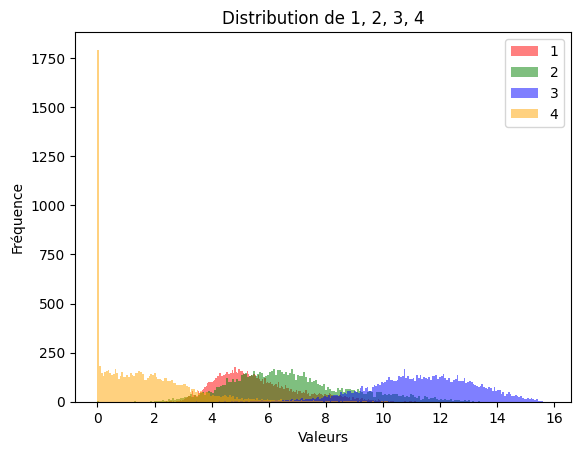

In [ ]:
plt.hist(generated_data[:,0], bins=200, alpha=0.5, color='red', label='1')
plt.hist(generated_data[:,1], bins=200, alpha=0.5, color='green', label='2')
plt.hist(generated_data[:,2], bins=200, alpha=0.5, color='blue', label='3')
plt.hist(generated_data[:,3], bins=200, alpha=0.5, color='orange', label='4')

plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Distribution de 1, 2, 3, 4')

plt.legend()

plt.show()

In [ ]:
statistic, p_value = ks_2samp(synthetic_data1.YIELD.to_numpy(), S1_test.YIELD.to_numpy())

statistic_ad, critical_values, significance_level = anderson_ksamp([synthetic_data1.YIELD.to_numpy(), S1_test.YIELD.to_numpy()])

print("Test de Anderson-Darling - Statistique :", statistic_ad)
print("Test de Anderson-Darling - Niveaux critiques :", critical_values)
print("Test de Anderson-Darling - Niveau de signification :", significance_level)

print("\n\n")

print("Statistique du test de Kolmogorov-Smirnov :", statistic)
print("P-value :", p_value)

Test de Anderson-Darling - Statistique : 2214.431421993078
Test de Anderson-Darling - Niveaux critiques : [0.325 1.226 1.961 2.718 3.752 4.592 6.546]
Test de Anderson-Darling - Niveau de signification : 0.001



Statistique du test de Kolmogorov-Smirnov : 0.41377107364685006
P-value : 9.096e-321


<ipython-input-28-faa7f575588c>:3: UserWarning: p-value floored: true value smaller than 0.001
  statistic_ad, critical_values, significance_level = anderson_ksamp([synthetic_data.YIELD.to_numpy(), S1_test.YIELD.to_numpy()])


In [ ]:
swd_distance = ot.sliced.sliced_wasserstein_distance(real_data1.YIELD.to_numpy().reshape((real_data1.shape[0],1)), synthetic_data1.YIELD.to_numpy().reshape((synthetic_data1.shape[0],1)))

print("Sliced Wasserstein Distance :", swd_distance)

Sliced Wasserstein Distance : 0.4928614273730513


In [ ]:
swd_distance = ot.sliced.sliced_wasserstein_distance(real_data1.YIELD.to_numpy().reshape((real_data1.shape[0],1)), S1_test.YIELD.to_numpy().reshape((S1_test.shape[0],1)))

print("Sliced Wasserstein Distance :", swd_distance)

Sliced Wasserstein Distance : 2.467606534054947


In [ ]:
synthetic_data1.shape

(10000, 19)